In [3]:
import functools
import itertools
import math

import matplotlib
from matplotlib import pyplot
import numpy as np
import scipy.integrate

import sys
sys.path.append("..")
from hiora_cartpole import fourier_fa
from hiora_cartpole import fourier_fa_int
from hiora_cartpole import offswitch_hfa
from hiora_cartpole import linfa
from hiora_cartpole import driver
from hiora_cartpole import interruptibility

import gym_ext.tools as gym_tools

import gym

In [4]:
def make_CartPole():
    return gym.make("CartPole-v0")

In [5]:
clipped_high = np.array([2.5, 3.6, 0.28, 3.7])
clipped_low  = -clipped_high
state_ranges = np.array([clipped_low, clipped_high])

four_n_weights, four_feature_vec \
    = fourier_fa.make_feature_vec(state_ranges,
                                  n_acts=2,
                                  order=3)

In [6]:
def make_uninterruptable_experience(choose_action=linfa.choose_action_Sarsa):
    return linfa.init(lmbda=0.9,
                        init_alpha=0.001,
                        epsi=0.1,
                        feature_vec=four_feature_vec,
                        n_weights=four_n_weights,
                        act_space=env.action_space,
                        theta=None,
                        is_use_alpha_bounds=True,
                        map_obs=functools.partial(gym_tools.warning_clip_obs, ranges=state_ranges),
                        choose_action=choose_action)

[2016-12-22 11:12:05,275] Making new env: CartPole-v0


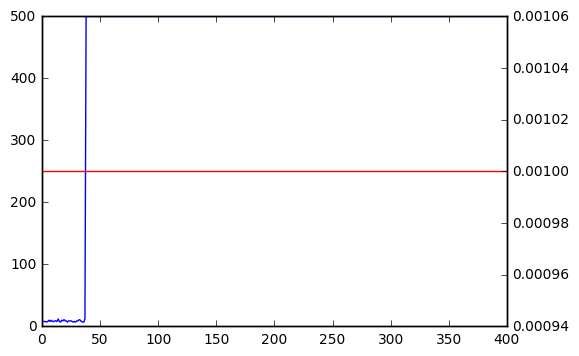

In [7]:
env         = make_CartPole()
fexperience = make_uninterruptable_experience()
fexperience, steps_per_episode, alpha_per_episode \
    = driver.train(env, linfa, fexperience, n_episodes=400, max_steps=500, is_render=False)
# Credits: http://matplotlib.org/examples/api/two_scales.html
fig, ax1 = pyplot.subplots()
ax1.plot(steps_per_episode, color='b')
ax2 = ax1.twinx()
ax2.plot(alpha_per_episode, color='r')
pyplot.show()

In [8]:
sr = state_ranges

def Q_at_x(e, x, a):
    return scipy.integrate.tplquad(
            lambda x_dot, theta, theta_dot: \
                e.feature_vec(np.array([x, x_dot, theta, theta_dot]), a)\
                    .dot(e.theta),
            sr[0][1],
            sr[1][1],
            lambda _: sr[0][2],
            lambda _: sr[1][2],
            lambda _, _1: sr[0][3],
            lambda _, _1: sr[1][3])

from multiprocessing import Pool
p = Pool(4)

def Q_fun(x):
    return Q_at_x(fexperience, x, 0)

num_Qs = np.array( map(Q_fun, np.arange(-2.38, 2.5, 0.5*1.19)) )
num_Qs

array([[ -2.31825193e+06,   1.38689230e-06],
       [ -2.38687849e+06,   7.01438119e-06],
       [  3.01868356e+07,   1.27310333e-05],
       [  7.62664231e+07,   1.95056604e-05],
       [  9.84923733e+07,   2.32515816e-05],
       [  7.75036104e+07,   2.02238501e-05],
       [  3.13949899e+07,   1.38010494e-05],
       [ -2.38605724e+06,   6.45226803e-06],
       [ -3.39609510e+06,   1.40739157e-06]])

In [9]:
sym_Q_s0 = fourier_fa_int.make_sym_Q_s0(state_ranges, 3)

In [10]:
sym_Qs = np.array( [sym_Q_s0(fexperience.theta, 0, s0) 
                         for s0 in np.arange(-2.38, 2.5, 0.5*1.19)] )
sym_Qs

array([ -2357917.42476503,  -2530447.06061102,  30011022.21107416,
        76201952.00856803,  98619287.76323849,  77753287.7212946 ,
        31609597.46793954,  -2308012.96767667,  -3417714.13839593])

In [20]:
num_Qs[:,0] / sym_Qs

array([ 0.98317774,  0.94326356,  1.00585829,  1.00084606,  0.99871309,
        0.99678885,  0.99321068,  1.03381449,  0.99367442])

In [21]:
num_Qs[:,0] - sym_Qs

array([  39665.49861224,  143568.56981984,  175813.36760074,
         64471.0686937 , -126914.48235117, -249677.3134065 ,
       -214607.59855561,  -78044.27264443,   21619.03838762])

In [57]:
np.prod(state_ranges[1,1:] - state_ranges[0,1:])

# Trying MountainCar

In [12]:
mc_env = gym.make("MountainCar-v0")

[2016-12-22 11:14:00,300] Making new env: MountainCar-v0


In [13]:
mc_n_weights, mc_feature_vec = fourier_fa.make_feature_vec(
                                np.array([mc_env.low, mc_env.high]),
                                n_acts=3,
                                order=2)

In [14]:
mc_experience = linfa.init(lmbda=0.9,
                        init_alpha=1.0,
                        epsi=0.1,
                        feature_vec=mc_feature_vec,
                        n_weights=mc_n_weights,
                        act_space=mc_env.action_space,
                        theta=None,
                        is_use_alpha_bounds=True)

In [15]:
mc_experience, mc_spe, mc_ape = driver.train(mc_env, linfa, mc_experience,
                                            n_episodes=400,
                                            max_steps=200,
                                            is_render=False)

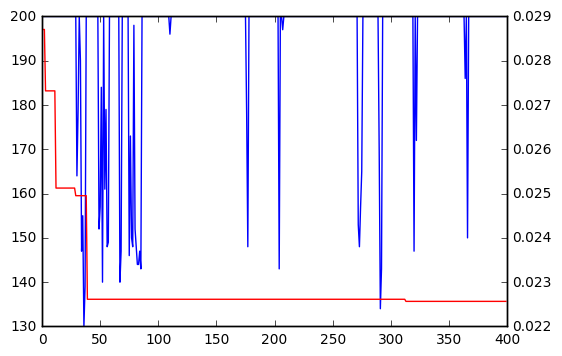

In [16]:
fig, ax1 = pyplot.subplots()
ax1.plot(mc_spe, color='b')
ax2 = ax1.twinx()
ax2.plot(mc_ape, color='r')
pyplot.show()

In [22]:
def mc_Q_at_x(e, x, a):
    return scipy.integrate.quad(
        lambda x_dot: e.feature_vec(np.array([x, x_dot]), a).dot(e.theta),
        mc_env.low[1],
        mc_env.high[1])

def mc_Q_fun(x):
    return mc_Q_at_x(mc_experience, x, 0)

sample_xs = np.arange(mc_env.low[0], mc_env.high[0], 
                      (mc_env.high[0] - mc_env.low[0]) / 8.0)

mc_num_Qs = np.array( map(mc_Q_fun, sample_xs) )
mc_num_Qs

array([[ -2.83006492e+03,   3.14200324e-11],
       [ -2.99082896e+03,   3.32048718e-11],
       [ -3.19937225e+03,   3.55201674e-11],
       [ -3.30639928e+03,   3.67084061e-11],
       [ -3.14982605e+03,   3.49700941e-11],
       [ -2.66485777e+03,   2.95858645e-11],
       [ -1.94577248e+03,   2.16274717e-11],
       [ -1.21959108e+03,   1.62129190e-11]])

In [23]:
mc_sym_Q_s0 = fourier_fa_int.make_sym_Q_s0(
                    np.array([mc_env.low, mc_env.high]),
                    2)

In [24]:
mc_sym_Qs = np.array( [mc_sym_Q_s0(mc_experience.theta, 0, s0)
                          for s0 in sample_xs] )
mc_sym_Qs 

array([-2830.06492278, -2990.82896295, -3199.37225304, -3306.39928082,
       -3149.82605152, -2664.85777008, -1945.77247978, -1219.5910843 ])

In [26]:
mc_sym_Qs - mc_num_Qs[:,0]

array([  0.00000000e+00,  -4.54747351e-13,  -9.09494702e-13,
        -4.54747351e-13,   0.00000000e+00,   0.00000000e+00,
         2.27373675e-13,   0.00000000e+00])

# Let's try some arbitrary thetas

And see what the ratio depends on. I've seen above that it's probably not the order of the Fourier FA, but the number of dimensions.

In [27]:
# Credits: http://stackoverflow.com/a/1409496/5091738
def make_integrand(feature_vec, theta, s0, n_dim):
    argstr = ", ".join(["s{}".format(i) for i in xrange(1, n_dim)])
    
    code = "def integrand({argstr}):\n" \
           "    return feature_vec(np.array([s0, {argstr}]), 0).dot(theta)\n" \
                .format(argstr=argstr)
            
    #print code
            
    compiled = compile(code, "fakesource", "exec")
    fakeglobals = {'feature_vec': feature_vec, 'theta': theta, 's0': s0,
                   'np': np}
    fakelocals = {}
    eval(compiled, fakeglobals, fakelocals)
    
    return fakelocals['integrand']

In [28]:
print make_integrand(None, None, None, 4)

<function integrand at 0x7fc7618410c8>


In [ ]:
for order in xrange(1,3):
    for n_dim in xrange(2, 4):
        print "\norder {} dims {}".format(order, n_dim)
        
        min_max = np.array([np.zeros(n_dim), 3 * np.ones(n_dim)])
        n_weights, feature_vec = fourier_fa.make_feature_vec(
                                    min_max,
                                    n_acts=1,
                                    order=order) 
        
        theta = np.cos(np.arange(0, 2*np.pi, 2*np.pi/n_weights))
        
        sample_xs = np.arange(0, 3, 0.3)
        
        def num_Q_at_x(s0):
            integrand = make_integrand(feature_vec, theta, s0, n_dim)
            return scipy.integrate.nquad(integrand,  min_max.T[1:])
        
        num_Qs =  np.array( map(num_Q_at_x, sample_xs) )
        #print num_Qs
        
        sym_Q_at_x = fourier_fa_int.make_sym_Q_s0(min_max, order)
        
        sym_Qs = np.array( [sym_Q_at_x(theta, 0, s0) for s0 in sample_xs] )
        #print sym_Qs
        
        print sym_Qs / num_Qs[:,0]


order 1 dims 2
[  5.15937205e-16   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00]

order 1 dims 3
[-1.76265599  1.          1.          1.          1.          1.          1.
  1.          1.          1.        ]

order 2 dims 2
[ 1.1241072  1.         1.         1.         1.         1.         1.         1.
  1.         1.       ]

order 2 dims 3


If the bounds of the states are [0, n], the ratio between symbolic and numeric results is $1/n^{n_{dim}-1}$. Or this is at least what I think I see.

This looks like there's a problem with normalization. (What also very strongly suggested it, was that numeric and symbolic results were equal over [0, 1], but started to differ when I changed to [0, 2].)

In [99]:
np.arange(0, 1, 10)

array([0])

In [12]:
import sympy as sp
a, b, x, f = sp.symbols("a b x f")

In [41]:
b_int = sp.Integral(1, (x, a, b))

In [14]:
sp.init_printing()

In [42]:
u_int = sp.Integral((1-a)/(b-a), (x, 0, 1))

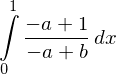

In [43]:
u_int

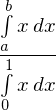

In [24]:
(b_int / u_int).simplify()

In [46]:
b_int.subs([(a,0), (b,2)]).doit()

In [47]:
u_int.subs([(a,0), (b,2)]).doit()

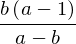

In [60]:
(u_int.doit()*b).simplify()